In [1]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d ryanholbrook/car-or-truck

 73% 57.0M/77.7M [00:00<00:00, 70.5MB/s]
100% 77.7M/77.7M [00:00<00:00, 89.3MB/s]


In [6]:
!unzip car-or-truck.zip

Streaming output truncated to the last 5000 lines.
  inflating: valid/Car/05205.jpeg    
  inflating: valid/Car/05206.jpeg    
  inflating: valid/Car/05208.jpeg    
  inflating: valid/Car/05213.jpeg    
  inflating: valid/Car/05214.jpeg    
  inflating: valid/Car/05217.jpeg    
  inflating: valid/Car/05218.jpeg    
  inflating: valid/Car/05219.jpeg    
  inflating: valid/Car/05221.jpeg    
  inflating: valid/Car/05222.jpeg    
  inflating: valid/Car/05225.jpeg    
  inflating: valid/Car/05226.jpeg    
  inflating: valid/Car/05227.jpeg    
  inflating: valid/Car/05228.jpeg    
  inflating: valid/Car/05234.jpeg    
  inflating: valid/Car/05236.jpeg    
  inflating: valid/Car/05238.jpeg    
  inflating: valid/Car/05239.jpeg    
  inflating: valid/Car/05241.jpeg    
  inflating: valid/Car/05242.jpeg    
  inflating: valid/Car/05245.jpeg    
  inflating: valid/Car/05248.jpeg    
  inflating: valid/Car/05249.jpeg    
  inflating: valid/Car/05250.jpeg    
  inflating: valid/Car/05252.jpeg    

In [7]:
# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [8]:
# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(31415)

In [9]:
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells

In [10]:
# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    '/content/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    '/content/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


In [11]:
# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Define Pretrained Base

The pretrained model used is called VGG16.

In [12]:
!kaggle datasets download -d ryanholbrook/cv-course-models

 97% 468M/481M [00:03<00:00, 161MB/s]
100% 481M/481M [00:03<00:00, 158MB/s]


In [13]:
!unzip cv-course-models.zip

Archive:  cv-course-models.zip
  inflating: cv-course-models/.ipynb_checkpoints/encyclopedia-of-course-models-checkpoint.ipynb  
  inflating: cv-course-models/.ipynb_checkpoints/inceptionv1-checkpoint.ipynb  
  inflating: cv-course-models/.ipynb_checkpoints/inceptionv1-checkpoint.md  
  inflating: cv-course-models/.ipynb_checkpoints/minivgg-bn-checkpoint.ipynb  
  inflating: cv-course-models/.ipynb_checkpoints/minivgg-bn-checkpoint.md  
  inflating: cv-course-models/.ipynb_checkpoints/minivgg-checkpoint.ipynb  
  inflating: cv-course-models/.ipynb_checkpoints/minivgg-checkpoint.md  
  inflating: cv-course-models/.ipynb_checkpoints/simple-cnn-bn-checkpoint.ipynb  
  inflating: cv-course-models/.ipynb_checkpoints/simple-cnn-bn-checkpoint.md  
  inflating: cv-course-models/.ipynb_checkpoints/simple-cnn-checkpoint.ipynb  
  inflating: cv-course-models/.ipynb_checkpoints/simple-cnn-checkpoint.md  
  inflating: cv-course-models/.ipynb_checkpoints/vgg16-checkpoint.ipynb  
  inflating: cv-cour

In [14]:
pretrained_base = tf.keras.models.load_model(
    '/content/cv-course-models/vgg16-pretrained-base',
)
pretrained_base.trainable = False

Attach Head

we'll use a layer of hidden units (the first Dense layer) followed by a layer to transform the outputs to a probability score for class 1, Truck.
 
The Flatten layer transforms the two dimensional outputs of the base into the one dimensional inputs needed by the head.

In [15]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    pretrained_base,
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

Training the model

Since this is a two-class problem, we'll use the binary versions of crossentropy and accuracy. 

In [16]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=30
)
history

Epoch 1/30
80/80 [==============================] - 50s 458ms/step - loss: 0.4754 - binary_accuracy: 0.7723 - val_loss: 0.3734 - val_binary_accuracy: 0.8390
Epoch 2/30
80/80 [==============================] - 32s 398ms/step - loss: 0.3473 - binary_accuracy: 0.8525 - val_loss: 0.3397 - val_binary_accuracy: 0.8559
Epoch 3/30
80/80 [==============================] - 31s 390ms/step - loss: 0.2982 - binary_accuracy: 0.8800 - val_loss: 0.3264 - val_binary_accuracy: 0.8628
Epoch 4/30
80/80 [==============================] - 32s 396ms/step - loss: 0.2643 - binary_accuracy: 0.8970 - val_loss: 0.3207 - val_binary_accuracy: 0.8666
Epoch 5/30
80/80 [==============================] - 31s 394ms/step - loss: 0.2381 - binary_accuracy: 0.9105 - val_loss: 0.3174 - val_binary_accuracy: 0.8652
Epoch 6/30
80/80 [==============================] - 31s 395ms/step - loss: 0.2168 - binary_accuracy: 0.9222 - val_loss: 0.3138 - val_binary_accuracy: 0.8687
Epoch 7/30
80/80 [==============================] - 32s 39

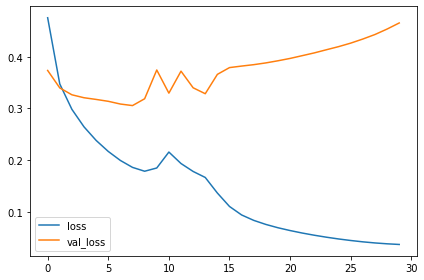

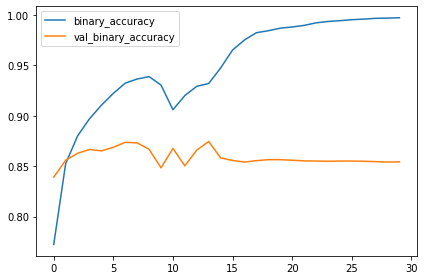

In [17]:
import pandas as pd

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

Testing inceptionv1 pretrained model

In [18]:
pretrained_base = tf.keras.models.load_model(
    '/content/cv-course-models/inceptionv1',
)
pretrained_base.trainable = False

In [20]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    pretrained_base,
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

In [21]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=30
)
history

Epoch 1/30
80/80 [==============================] - 13s 93ms/step - loss: 0.4912 - binary_accuracy: 0.7571 - val_loss: 0.4131 - val_binary_accuracy: 0.8190
Epoch 2/30
80/80 [==============================] - 5s 63ms/step - loss: 0.3909 - binary_accuracy: 0.8231 - val_loss: 0.3836 - val_binary_accuracy: 0.8349
Epoch 3/30
80/80 [==============================] - 5s 67ms/step - loss: 0.3629 - binary_accuracy: 0.8407 - val_loss: 0.3683 - val_binary_accuracy: 0.8390
Epoch 4/30
80/80 [==============================] - 5s 65ms/step - loss: 0.3436 - binary_accuracy: 0.8513 - val_loss: 0.3591 - val_binary_accuracy: 0.8452
Epoch 5/30
80/80 [==============================] - 5s 65ms/step - loss: 0.3289 - binary_accuracy: 0.8626 - val_loss: 0.3512 - val_binary_accuracy: 0.8483
Epoch 6/30
80/80 [==============================] - 5s 64ms/step - loss: 0.3171 - binary_accuracy: 0.8691 - val_loss: 0.3447 - val_binary_accuracy: 0.8505
Epoch 7/30
80/80 [==============================] - 5s 64ms/step - lo

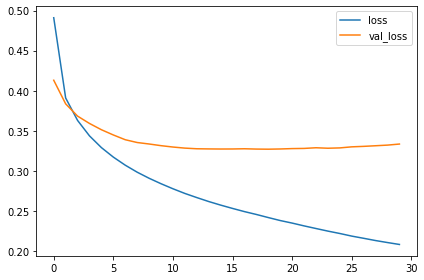

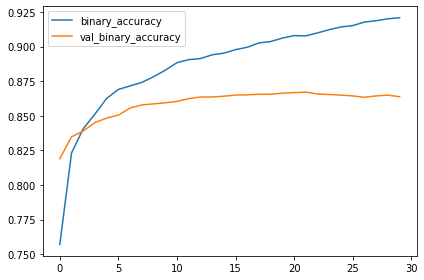

In [22]:
import pandas as pd

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

We can see difference between the learning curves from inceptionv1 and learing curves from VGG16.

Explanation:

The training loss and validation loss stay fairly close is evidence that the model isn't just memorizing the training data, but rather learning general properties of the two classes.

Designing a custom Convnet to classify Cars and Trucks

In [23]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([

    # First Convolutional Block
    layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding='same',
                  # give the input dimensions in the first layer
                  # [height, width, color channels(RGB)]
                  input_shape=[128, 128, 3]),
    layers.MaxPool2D(),

    # Second Convolutional Block
    layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
    layers.MaxPool2D(),
    # Third Convolutional Block
    layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
    layers.MaxPool2D(),

    # Classifier Head
    layers.Flatten(),
    layers.Dense(units=6, activation="relu"),
    layers.Dense(units=1, activation="sigmoid"),
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 128)     

In [24]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=30,
)

Epoch 1/30
80/80 [==============================] - 8s 73ms/step - loss: 0.6796 - binary_accuracy: 0.5722 - val_loss: 0.6713 - val_binary_accuracy: 0.5785
Epoch 2/30
80/80 [==============================] - 5s 63ms/step - loss: 0.6648 - binary_accuracy: 0.6029 - val_loss: 0.6573 - val_binary_accuracy: 0.6129
Epoch 3/30
80/80 [==============================] - 5s 63ms/step - loss: 0.6568 - binary_accuracy: 0.6142 - val_loss: 0.6560 - val_binary_accuracy: 0.5969
Epoch 4/30
80/80 [==============================] - 5s 64ms/step - loss: 0.6489 - binary_accuracy: 0.6238 - val_loss: 0.6554 - val_binary_accuracy: 0.5959
Epoch 5/30
80/80 [==============================] - 5s 64ms/step - loss: 0.6391 - binary_accuracy: 0.6353 - val_loss: 0.6488 - val_binary_accuracy: 0.6009
Epoch 6/30
80/80 [==============================] - 5s 64ms/step - loss: 0.6270 - binary_accuracy: 0.6478 - val_loss: 0.6386 - val_binary_accuracy: 0.6145
Epoch 7/30
80/80 [==============================] - 5s 63ms/step - los

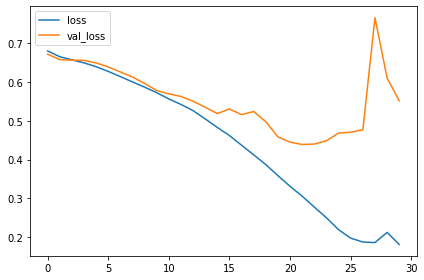

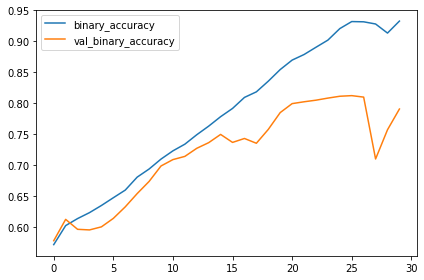

In [25]:
import pandas as pd

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

This model is much smaller than the VGG16 model only 3 convolutional layers versus the 16 of VGG16. It was nevertheless able to fit this dataset fairly well. We might still be able to improve this simple model by adding more convolutional layers, hoping to create features better adapted to the dataset. 